## A.4.3: Lead ID: HTS Data Analysis

In [51]:
# imports 
import pandas as pd
import numpy as np
import os
import glob
# imports for plotting 
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Compute Z-Prime for each screening plate and split the screening plates into 'good' assay quality and 'bad' assay quality

In [52]:
# Function that calculates Z-Prime
def calc_z_prime(pos_control, neg_control):
    # calculate means of the positive and negative columns
    pos_mean = np.mean(pos_control)
    neg_mean = np.mean(neg_control)

    # calculate standard deviation of the positive and negative columns
    pos_stdev = np.std(pos_control)
    neg_stdev = np.std(neg_control)

    # Calc z-prime
    z_prime = 1-(3*(pos_stdev + neg_stdev))/abs(pos_mean-neg_mean)
    return(z_prime)

In [53]:
# get plates in unzipped screening_plates/ folder
# get file names
plate_files = sorted(glob.glob(os.path.join('screening_plates', '*.csv')))

# array to collect the z prime scores 
z_prime_results = []
# array to collect the ids of the bad quality plates and the good quality plates (used for subtask 3)
bad_plates = []
good_plates = []


# Loop over each file/plate and determine for each plate what the z-prime score is and if the quality of this plate is good or bad
for plate_file in plate_files:
    plate_id = os.path.basename(plate_file).replace('.csv', '')
    
    # Read CSV file
    plate = pd.read_csv(plate_file)

    # get the raw values from the positive and negative control columns from current plate
    pos_control = plate[plate['Plate_Col'] == 1]['Raw_value']
    neg_control = plate[plate['Plate_Col'] == 24]['Raw_value']

    # calculate the z-prime score for this plate
    z_prime = calc_z_prime(pos_control, neg_control)
    z_prime_results.append({'Plate_ID': plate_id, 'Z_prime': z_prime})

    # Classify plate quality
    if z_prime <= 0.5:
        bad_plates.append(plate_id)
    else:
        good_plates.append(plate_id)
    
# Convert results to DataFrame and output
z_prime_df = pd.DataFrame(z_prime_results)

# Print Plate_IDs of 'bad' plates to command line, comma-separated
print("Bad Plate IDs (z' ≤ 0.5):")
print(','.join(bad_plates))


Bad Plate IDs (z' ≤ 0.5):
HT_VIABILITY_SCREENING_090,HT_VIABILITY_SCREENING_091,HT_VIABILITY_SCREENING_092,HT_VIABILITY_SCREENING_093,HT_VIABILITY_SCREENING_094,HT_VIABILITY_SCREENING_095,HT_VIABILITY_SCREENING_096,HT_VIABILITY_SCREENING_097,HT_VIABILITY_SCREENING_098,HT_VIABILITY_SCREENING_099,HT_VIABILITY_SCREENING_100,HT_VIABILITY_SCREENING_101,HT_VIABILITY_SCREENING_102,HT_VIABILITY_SCREENING_103,HT_VIABILITY_SCREENING_104,HT_VIABILITY_SCREENING_105,HT_VIABILITY_SCREENING_106,HT_VIABILITY_SCREENING_107,HT_VIABILITY_SCREENING_108,HT_VIABILITY_SCREENING_109,HT_VIABILITY_SCREENING_110,HT_VIABILITY_SCREENING_111,HT_VIABILITY_SCREENING_112,HT_VIABILITY_SCREENING_113,HT_VIABILITY_SCREENING_114,HT_VIABILITY_SCREENING_115,HT_VIABILITY_SCREENING_116,HT_VIABILITY_SCREENING_117,HT_VIABILITY_SCREENING_118,HT_VIABILITY_SCREENING_119,HT_VIABILITY_SCREENING_120,HT_VIABILITY_SCREENING_121,HT_VIABILITY_SCREENING_122,HT_VIABILITY_SCREENING_123,HT_VIABILITY_SCREENING_124,HT_VIABILITY_SCREENING_125,HT

### 2. Visualize one good and one bad screening plate by generating heat maps

In [54]:
# Set plot aesthetics
sns.set(style='whitegrid')

# Function to plot one plate
def plot_plate_heatmap(data, title):
    """Plot a heatmap of the screening plate data."""
    plt.figure(figsize=(12, 6))
    sns.heatmap(data, cmap='viridis', cbar_kws={'label': 'Measurement Value'}, linewidths=0.5)
    plt.title(title)
    plt.xlabel('Column')
    plt.ylabel('Row')
    plt.tight_layout()
    plt.show()

0.7067832424416784
0.15462433126381814


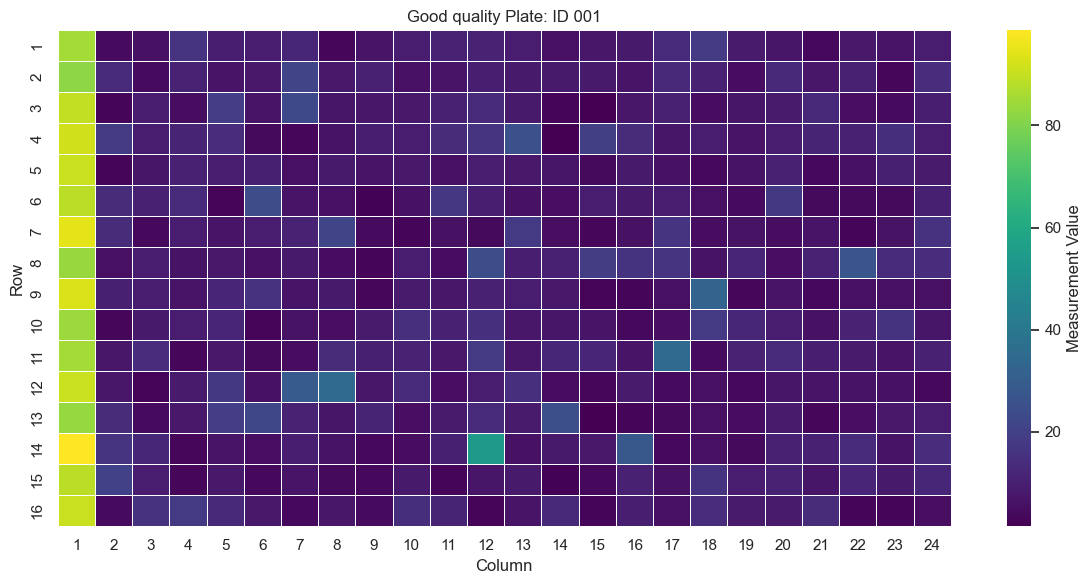

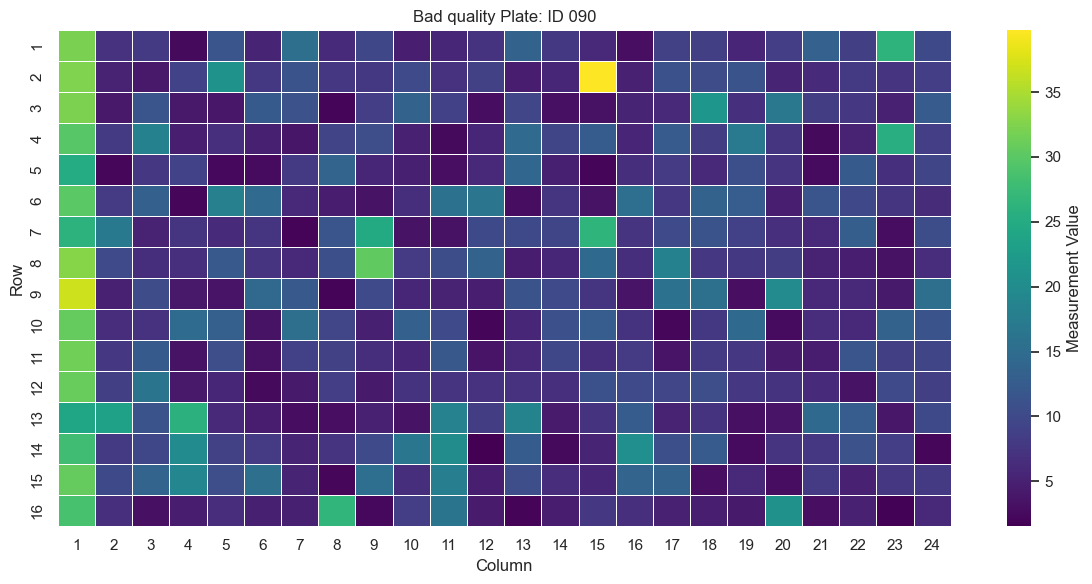

In [55]:
# Read one good quality plate and one bad quality plate
good_plate = pd.read_csv("screening_plates/HT_VIABILITY_SCREENING_001.csv")
bad_plate = pd.read_csv("screening_plates/HT_VIABILITY_SCREENING_090.csv")

# double check if the good plate really has a z prime score larger than 0.5, and the bad plate one smaller than or equal to 0.5
pos_control_good_plate = good_plate[good_plate['Plate_Col'] == 1]['Raw_value']
neg_control_good_plate = good_plate[good_plate['Plate_Col'] == 24]['Raw_value']

pos_control_bad_plate = bad_plate[bad_plate['Plate_Col'] == 1]['Raw_value']
neg_control_bad_plate = bad_plate[bad_plate['Plate_Col'] == 24]['Raw_value']

z_prime_good_plate = calc_z_prime(pos_control_good_plate, neg_control_good_plate)
z_prime_bad_plate = calc_z_prime(pos_control_bad_plate, neg_control_bad_plate)
print(z_prime_good_plate) # This value is larger than 0.5 --> good quality
print(z_prime_bad_plate) # This value is smaller than 0.5 --> bad quality

# Pivot the plate data to 2D grid so that it can be plotted 
good_plate_pivoted = good_plate.pivot(index='Plate_Row', columns='Plate_Col', values='Raw_value')
bad_plate_pivoted = bad_plate.pivot(index='Plate_Row', columns='Plate_Col', values='Raw_value')

# Plot both plates
plot_plate_heatmap(good_plate_pivoted, 'Good quality Plate: ID 001')
plot_plate_heatmap(bad_plate_pivoted, 'Bad quality Plate: ID 090')



In the good quality plate we can see clearly, that we have a uniformly strong signal in the positive control column and a low signal in the negative control column. For the bad quality plate this is not so clear. We have a higher variance in the positive and negative control columns, for example in the negative control column, instead of having only values around 0 (dark blue) we have some values around 10-20, which should not be the case for the negative control. This could be the source of the bad quality. 

### 3. Normalize the 'good' plates using normalized percent inhibition. Pick hits by removing compunds with values smaller than 70% NPI. 

In [56]:
# Print Hits using NPI
print("Hits (good quality plates normalized with NPI):")
print("")

for plate_file in good_plates:
    file_path = "screening_plates/"+plate_file+".csv"
    good_plate = pd.read_csv(file_path)

    # get the raw values from the positive and negative control columns from current plate
    pos_control = good_plate[good_plate['Plate_Col'] == 1]['Raw_value']
    neg_control = good_plate[good_plate['Plate_Col'] == 24]['Raw_value']

    # calculate means of the positive and negative columns
    pos_mean = np.mean(pos_control)
    neg_mean = np.mean(neg_control)

    # Calculate NPI for samples only (excluding controls)
    sample_df = good_plate[(good_plate['Plate_Col'] != 1) & (good_plate['Plate_Col'] != 24)].copy()
    sample_df['NPI'] = 100 * (neg_mean - sample_df['Raw_value']) / (neg_mean - pos_mean)

    # Filter for hits with NPI ≥ 70
    hits = sample_df[sample_df['NPI'] >= 70]
    
    for _, hit in hits.iterrows():
        compound_id = hit['Sample']
        npi_value = round(hit['NPI'], 2)  # Round for cleaner output

        # Print in given format
        print(f"{compound_id} npi {npi_value}")


Hits (good quality plates normalized with NPI):

TP004-07-20 npi 87.69
TP009-06-19 npi 73.21
TP018-03-07 npi 75.9
TP020-12-13 npi 91.7
TN056-15-08 npi 122.59
TP070-13-18 npi 70.59
TP156-03-07 npi 78.41
TN191-01-22 npi 124.52
TP199-07-07 npi 76.89
TP210-10-10 npi 71.08
TP211-13-21 npi 71.9
TP248-08-03 npi 70.82
TP258-16-04 npi 85.82
TP264-12-18 npi 87.09
TN269-03-13 npi 145.89
TP287-01-23 npi 76.31
TP303-05-13 npi 72.2
TP341-04-19 npi 73.91
TP379-03-22 npi 75.8
TP384-12-19 npi 89.32
TN393-10-03 npi 101.15
TP410-04-04 npi 94.03
TN419-11-17 npi 110.86
TP446-04-12 npi 76.67


### 4. Normalize the 'bad' plates using z-score normalization. Pick hits by removing compunds with z-score < 8.0>.

In [57]:
# Print Hits of bad quality plates normalizing with z-score
print("Hits (bad quality plates normalized with z-score):")
print("")

for plate_file in bad_plates:
    file_path = "screening_plates/"+plate_file+".csv"
    bad_plate = pd.read_csv(file_path)

    # get the raw values from the positive and negative control columns from current plate
    pos_control = bad_plate[bad_plate['Plate_Col'] == 1]['Raw_value']
    neg_control = bad_plate[bad_plate['Plate_Col'] == 24]['Raw_value']

    # Calculate z-score for samples only (excluding controls)
    sample_df = bad_plate[(bad_plate['Plate_Col'] != 1) & (bad_plate['Plate_Col'] != 24)].copy()
    
    mean = np.mean(sample_df['Raw_value'])
    stdev = np.std(sample_df['Raw_value'])

    # Avoid division by zero
    if stdev == 0:
        continue

    # Z-score normalization
    sample_df['zscore'] = (sample_df['Raw_value'] - mean) / stdev
    
    # Find hits with z-score < 8 (extremely low signal) 
    hits = sample_df[sample_df['zscore'] >= 8.0]

    for _, hit in hits.iterrows():
        compound_id = hit['Sample']
        z_score = round(hit['zscore'], 2)  # Round for cleaner output

        # Print in given format
        print(f"{compound_id} zscore {z_score}")

Hits (bad quality plates normalized with z-score):

TN101-12-13 zscore 8.48
TP141-04-20 zscore 8.05
TP145-10-02 zscore 8.19
TP146-08-08 zscore 9.24


### Why can z-score normalization be used in this case?

The z-score takes the mean and standard deviation of the values of a plate into account during normalization, while the NPI uses the control columns for normalization. This means, that even though the assay quality is bad, one could still find hits by comparing each compound's measurement to the overall distribution of the plate values. So one could still find strong hits, even if the control columns are not reliable. 